# Load libraries

In [42]:
import numpy as np
import os
import cv2
import glob as gb
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input , BatchNormalization, Dropout ,Conv2DTranspose

print("model loaded ")


model loaded 


In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

In [3]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

In [4]:
def normalize(input_image, input_mask):
    input_image = input_image / 255.0
    input_mask = input_mask / 255.0
    return input_image, input_mask

# Read data

In [5]:
def load_data(train_dir):
    X=[]
    Y=[]

    for folder in tqdm(os.listdir(train_dir)):
        folder_path = os.path.join(train_dir, folder)

        if not os.path.isdir(folder_path):
            continue

        # Load images
        image_files = sorted(gb.glob(os.path.join(folder_path, 'image', '*.png')))
        for file in image_files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Unable to load image {file}")
                continue
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
            X.append(img)

        # Load masks
        mask_files = sorted(gb.glob(os.path.join(folder_path, 'mask', '*.png')))
        for file in mask_files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Unable to load mask {file}")
                continue
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
            Y.append(img)
    X = np.array(X)
    Y = np.array(Y)
    X,Y = normalize(X,Y)
     
    # Split the data
    x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size= int(len(X)*0.2), random_state=42 , shuffle = True)
    x_train, y_train = augment(x_train, y_train)
        
    return  x_train, x_valid, y_train, y_valid

In [6]:
x_train, x_valid, y_train, y_valid = load_data('/kaggle/input/ct-heart-segmentation/data/train')

100%|██████████| 19/19 [00:31<00:00,  1.63s/it]


In [7]:
len(x_train)

2026

# Some visualization of traing data 

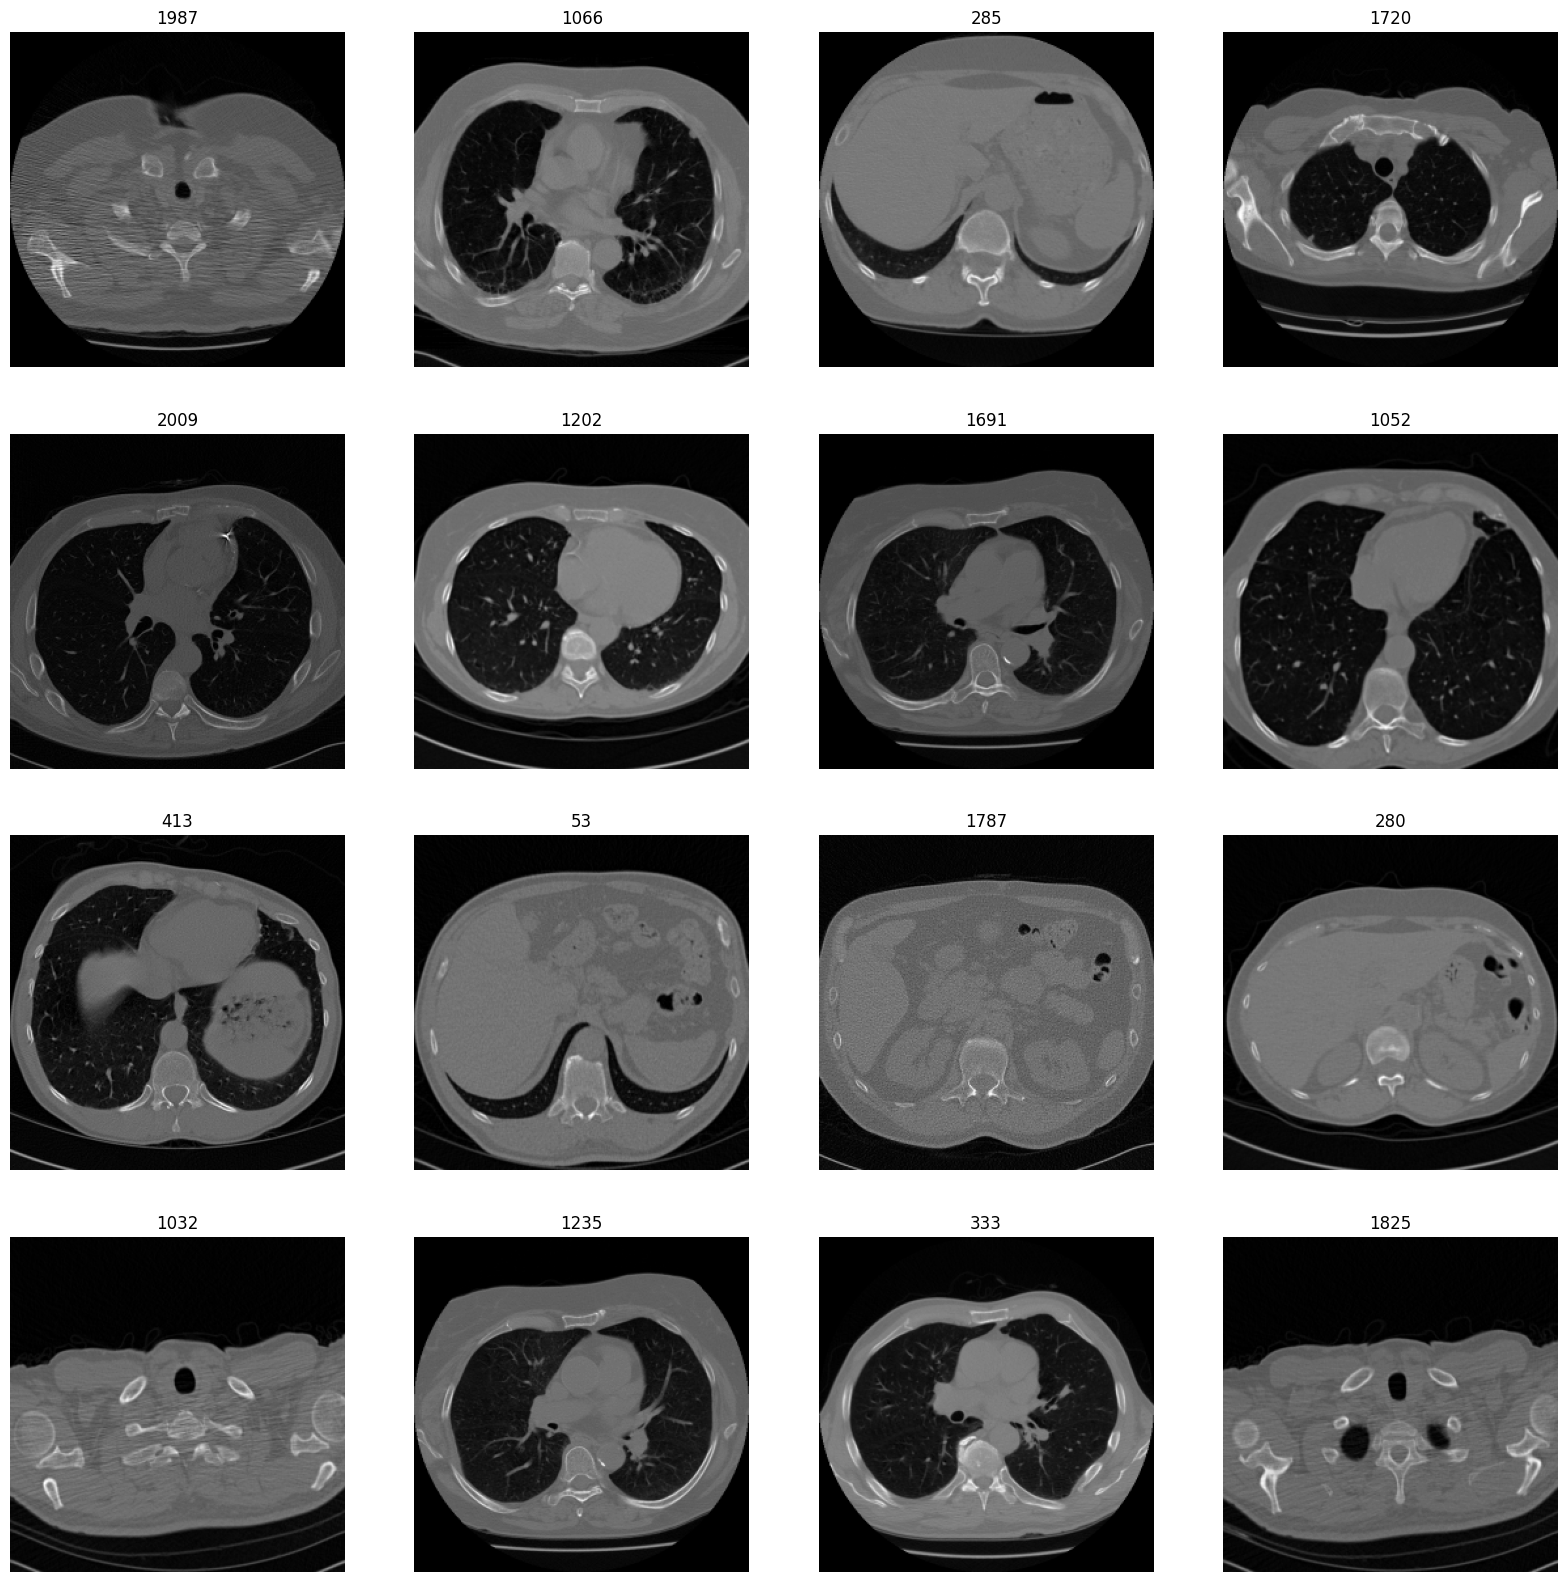

In [8]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(x_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(x_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

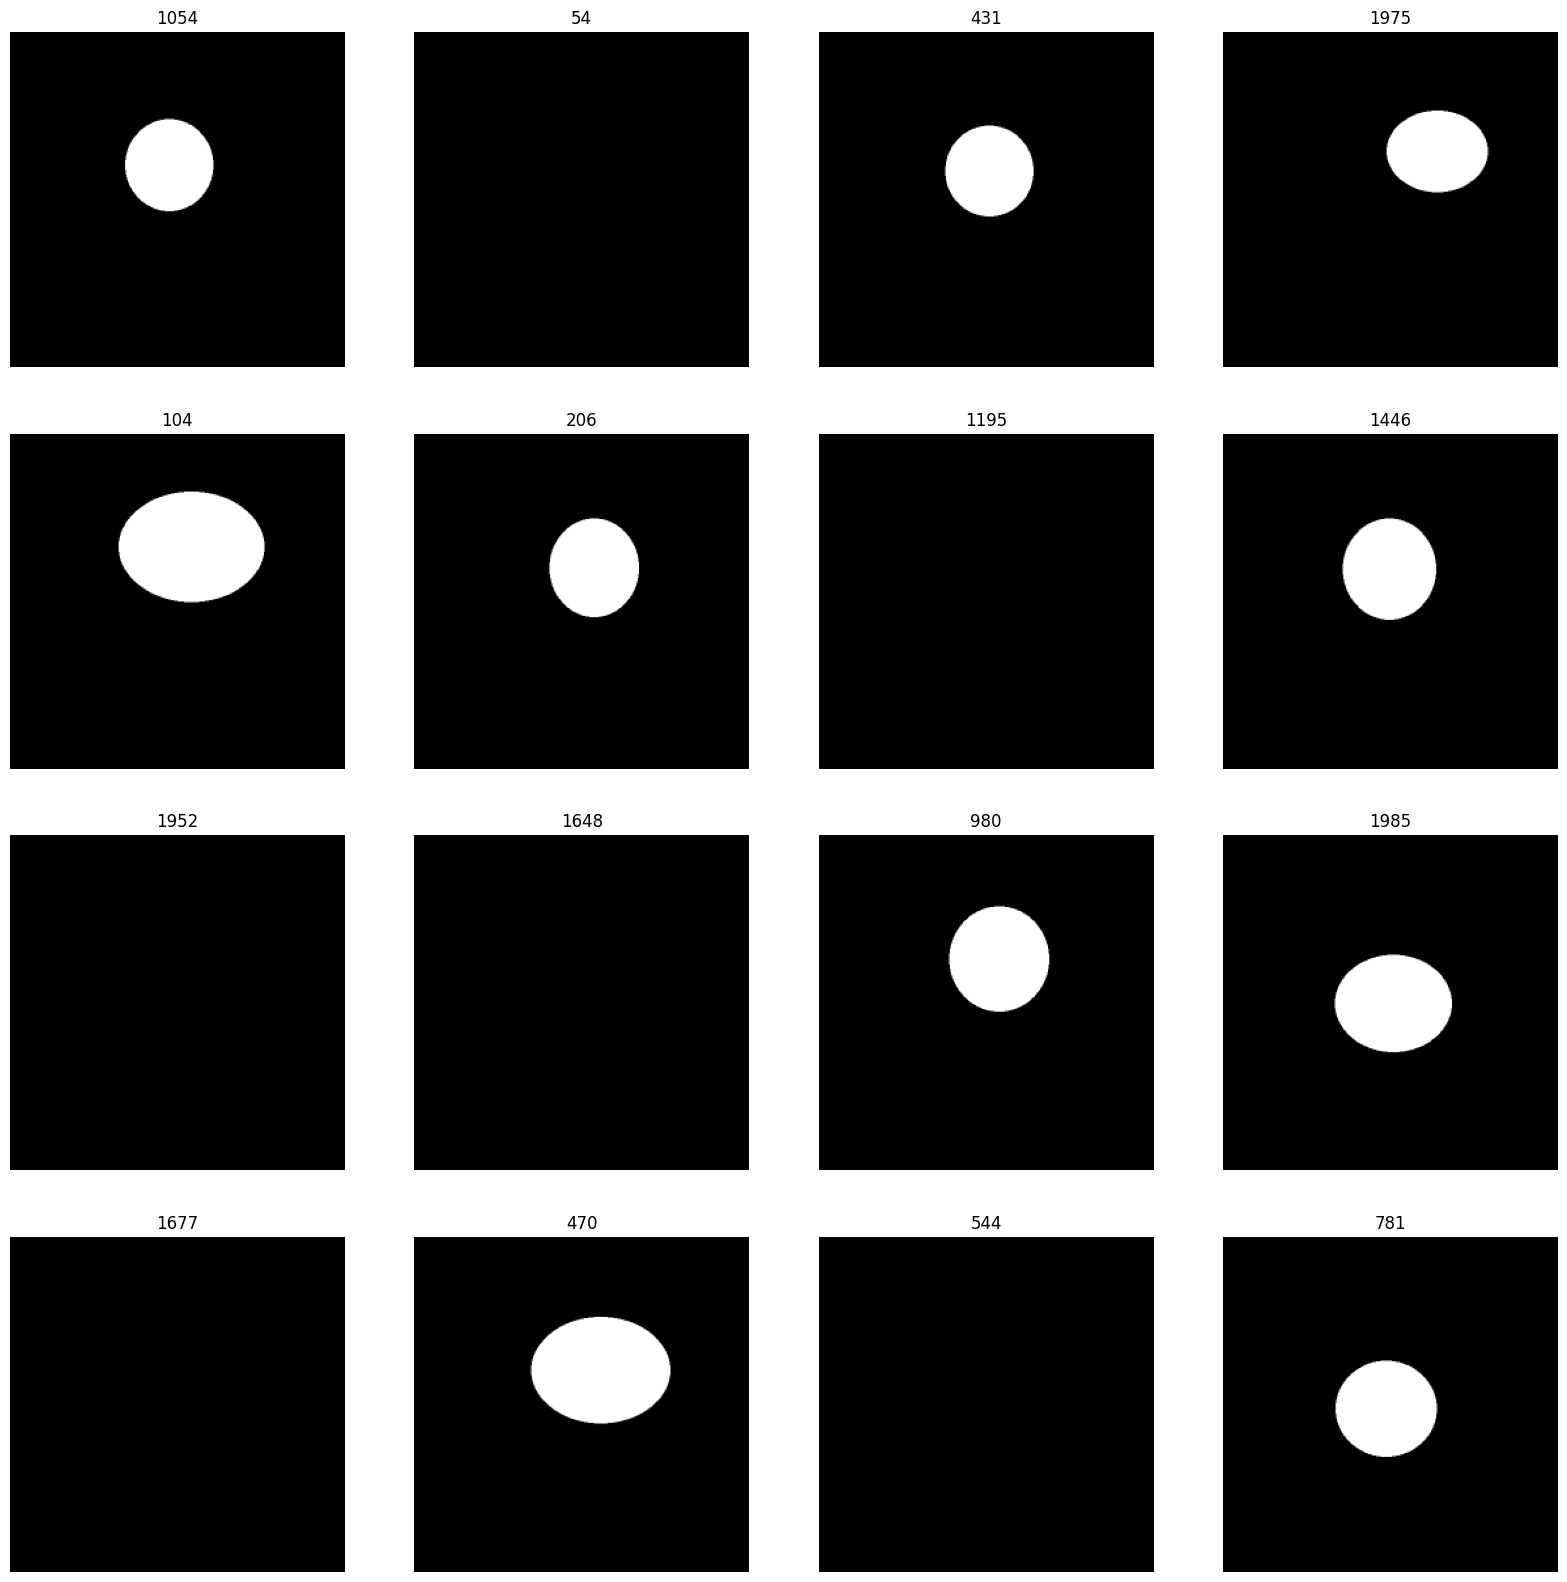

In [9]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(y_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

# Define U-Net model architecture

In [10]:
def conv_block(input, num_filters):
    
    x = Conv2D(num_filters, 3, activation='relu', padding="same",
               kernel_initializer = "he_normal")(input)
    x = Dropout(0.45,seed=123)(x)
    x = Conv2D(num_filters, 3, activation='relu', padding="same",kernel_initializer = "he_normal")(x)
    return x

In [11]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

In [12]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [13]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    # encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # bottleneck
    b1 = conv_block(p4, 1024)

    # decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # outputs
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    # unet model with Keras Functional API
    model = Model(inputs, outputs, name="U-Net")
    
    model.compile(Adam(learning_rate= 0.0001), loss= 'binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [14]:
input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
model = build_unet(input_shape)

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ dropout_3[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

EarlyStop=EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callback=[EarlyStop]

# Train the model

In [16]:
history=model.fit(x_train,y_train,validation_data = (x_valid,y_valid) ,
                  batch_size=32 ,epochs=50,
                 callbacks=callback,verbose=1)

Epoch 1/50


2024-09-01 08:27:56.716864: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 1.05936, expected 0.681349
2024-09-01 08:27:56.716935: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 2.21753, expected 1.83952
2024-09-01 08:27:56.716954: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 2.5462, expected 2.16819
2024-09-01 08:27:56.716967: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65539: 2.07291, expected 1.6949
2024-09-01 08:27:56.716977: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65540: 2.56529, expected 2.18728
2024-09-01 08:27:56.716989: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65542: 2.19261, expected 1.8146
2024-09-01 08:27:56.716999: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65543: 1.83463, expected 1.45662
2024-09-01 08:27:56.717009: E

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9143 - loss: 0.6926

2024-09-01 08:30:43.284697: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 0.667336, expected 0.458389
2024-09-01 08:30:43.284759: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65547: 0.884515, expected 0.675568
2024-09-01 08:30:43.284773: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65549: 0.949993, expected 0.741046
2024-09-01 08:30:43.284787: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65566: 0.972961, expected 0.764015
2024-09-01 08:30:43.284805: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65568: 0.929757, expected 0.72081
2024-09-01 08:30:43.284818: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65603: 0.880601, expected 0.671654
2024-09-01 08:30:43.284829: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65604: 1.04196, expected 0.83301
2024-09-01 08:30

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9149 - loss: 0.6901   

2024-09-01 08:31:37.090419: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 0.996822, expected 0.222233
2024-09-01 08:31:37.090486: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.13006, expected 1.35547
2024-09-01 08:31:37.090503: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.12424, expected 1.34965
2024-09-01 08:31:37.090520: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.08803, expected 1.31344
2024-09-01 08:31:37.090541: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.56675, expected 1.79216
2024-09-01 08:31:37.090556: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.61586, expected 1.84127
2024-09-01 08:31:37.090568: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1.96778, expected 1.19319
2024-09-01 08:31:37.090582: E external/local_xla/xla/

64/64 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.9156 - loss: 0.6876 - val_accuracy: 0.9679 - val_loss: 0.5088
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 755ms/step - accuracy: 0.9680 - loss: 0.5080 - val_accuracy: 0.9679 - val_loss: 0.5088
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 726ms/step - accuracy: 0.9704 - loss: 0.4705 - val_accuracy: 0.9679 - val_loss: 0.5088
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 726ms/step - accuracy: 0.9691 - loss: 0.4907 - val_accuracy: 0.9679 - val_loss: 0.5088
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 726ms/step - accuracy: 0.9690 - loss: 0.4916 - val_accuracy: 0.9679 - val_loss: 0.5088
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 726ms/step - accuracy: 0.9691 - loss: 0.4909 - val_accuracy: 0.9679 - val_loss: 0.5088
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 725ms/step - accuracy: 0.9712 - loss: 0.4577 - val_accuracy: 0.9679 - val_loss: 0.5088
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 726ms/step - accuracy: 0.9692 - loss: 0.4894 - val_accuracy: 0.9679 

# Evaluate the U-Net model

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|████      | 2/5 [00:00<00:00,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████  | 4/5 [00:00<00:00,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|██████████| 5/5 [00:00<00:00,  9.91it/s]

Image 425 - Acc: 1.00, F1: 1.00, Jaccard: 1.00, Recall: 1.00, Precision: 1.00
Image 78 - Acc: 0.96, F1: 0.00, Jaccard: 0.00, Recall: 0.00, Precision: 1.00
Image 337 - Acc: 1.00, F1: 1.00, Jaccard: 1.00, Recall: 1.00, Precision: 1.00
Image 378 - Acc: 1.00, F1: 1.00, Jaccard: 1.00, Recall: 1.00, Precision: 1.00
Image 200 - Acc: 1.00, F1: 1.00, Jaccard: 1.00, Recall: 1.00, Precision: 1.00


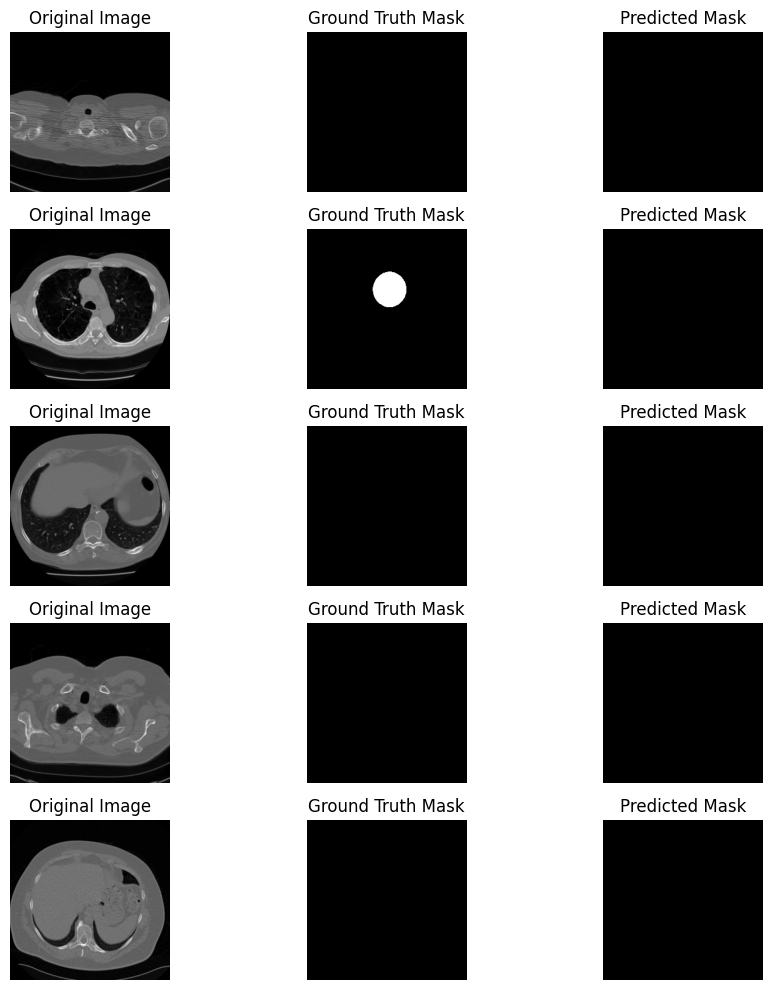

In [40]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

H = 256
W = 256

# Load the dataset
test_x = x_valid  
test_y = y_valid

# Randomly select 5 indices without fixing the seed
random_indices = np.random.choice(len(test_x), size=5, replace=False)

SCORE = []
examples = []  # To store example images for display

for idx in tqdm(random_indices):
    x = test_x[idx]  # Get the selected image
    y = test_y[idx]  # Get the corresponding mask

    image = x  # x is already the image (normalized)
    x = np.expand_dims(image, axis=0)  # Add batch dimension

    # Ensure the mask is binary
    mask = (y > 0.5).astype(np.int32)

    # Prediction
    y_pred = model.predict(x)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = (y_pred > 0.5).astype(np.int32)  # Convert to binary

    # Store the image, mask, and prediction for display
    examples.append((image, mask, y_pred))

    # Flatten the arrays for metrics
    y_flat = mask.flatten()
    y_pred_flat = y_pred.flatten()

    # Calculating the metrics values
    acc_value = accuracy_score(y_flat, y_pred_flat)
    f1_value = f1_score(y_flat, y_pred_flat, labels=[0, 1], average="binary", zero_division=1)
    jac_value = jaccard_score(y_flat, y_pred_flat, labels=[0, 1], average="binary", zero_division=1)
    recall_value = recall_score(y_flat, y_pred_flat, labels=[0, 1], average="binary", zero_division=1)
    precision_value = precision_score(y_flat, y_pred_flat, labels=[0, 1], average="binary", zero_division=1)
    
    SCORE.append([f"Image {idx + 1}", acc_value, f1_value, jac_value, recall_value, precision_value])

# Print all SCORE values
for score in SCORE:
    print(f"{score[0]} - Acc: {score[1]:.2f}, F1: {score[2]:.2f}, Jaccard: {score[3]:.2f}, Recall: {score[4]:.2f}, Precision: {score[5]:.2f}")

# Plotting the results
plt.figure(figsize=(10, 10))
for i, (img, mask, pred) in enumerate(examples):
    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 3)
    plt.imshow(pred, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()